In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, SAGEConv

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Load the main CosMx file
adata = sc.read_h5ad("sccellfie_results_new/1209622B/1209622B.h5ad")

# Load metabolic task scores
adata_tasks = sc.read_h5ad("sccellfie_results_new/1209622B/1209622B_metabolic_tasks.h5ad")

# Load reaction activities
adata_rxn = sc.read_h5ad("sccellfie_results_new/1209622B/1209622B_reactions.h5ad")

In [4]:
adata.obsm["met_tasks"] = adata_tasks.X
adata.uns["met_task_names"] = list(adata_tasks.var_names)
adata.obsm["rxn"] = adata_rxn.X
adata.uns["rxn_names"] = list(adata_rxn.var_names)

In [5]:
adata

AnnData object with n_obs × n_vars = 170619 × 24
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_ID', 'fov', 'Area', 'TMA', 'Subject_ID', 'Treatment_Status', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'Lineage_level2', 'Lineage_level1', 'Lineage_level3', 'Lineage_level4'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'Lineage_level3_colors', 'Lineage_level4_colors', 'log1p', 'neighbors_30', 'normalization', 'pca', 'umap', 'met_task_names', 'rxn_names'
    obsm: 'X_pca', 'X_umap', 'spatial', 'met_tasks', 'rxn'
    varm: 'PCs'
    layers: 'counts', 'gene_scores', 'log_norm', 'norm_counts', 'raw_counts', 'smoothed_X'
    obsp: 'neighbors_30_connectivities', 'neighbors_30_distances'

In [6]:
# =========================
# STAGED-like (Snapshot -> Pseudotime -> GNN Dynamics)
# Two graphs: spatial + metabolic similarity
# Train: predict dx that moves cells forward in pseudotime bins
# Inference: roll forward to generate new states
# =========================

In [7]:
# -------------------------
# 0) Utilities
# -------------------------
def to_dense(X):
    if sp.issparse(X):
        return X.toarray()
    return np.asarray(X)

def zscore(X, eps=1e-6):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + eps
    return (X - mu) / sd, mu, sd


In [8]:
# -------------------------
# 1) Filter T cells
# -------------------------
tcell_names = [
    "Treg", "CD8_CM", "CD8_EM", "CD8_TEMRA",
    "CD4_EM", "CD4_CM", "CD8_Naive", "CD4_Naive",
    "gdT", "MAIT"
]

tcell = adata[adata.obs["Lineage_level4"].isin(tcell_names)].copy()
print("T cells:", tcell.n_obs)

T cells: 2446


In [ ]:
# -------------------------
# 2) TIL score: Weighted TIL proximity score (sum the edge weights connecting it to neighboring malignant 
# cells in the 30-nearest-neighbor graph)
### How strongly this cell is spatially connected to tumor cells
# -------------------------
'''This block computes a weighted Tumor-Infiltrating Lymphocyte (TIL) proximity score based 
on the kNN spatial graph. For each cell, we sum the edge weights connecting it to neighboring malignant 
cells in the 30-nearest-neighbor graph.
This score captures spatial proximity to malignant cells, where closer neighbors contribute more due 
to higher connectivity weights. The score is then extracted for T cells and z-score normalized to 
allow comparison across cells. '''
    
mal_mask = (adata.obs["Lineage_level4"] == "Malignant").to_numpy()

G_full = adata.obsp["neighbors_30_connectivities"].tocsr()  # (N x N) sparse

til_all = np.asarray(G_full[:, mal_mask].sum(axis=1)).ravel()

# Finding T-Cell index
idx_t = np.array([adata.obs_names.get_loc(n) for n in tcell.obs_names])

tcell.obs["TIL_score"] = til_all[idx_t]
tcell.obs["TIL_score_z"] = (tcell.obs["TIL_score"] - tcell.obs["TIL_score"].mean()) / (tcell.obs["TIL_score"].std() + 1e-8)
tcell.obs["TIL_score"]

TMA3_436_1       0.000000
TMA3_35_2        0.000000
TMA3_167_2       2.698387
TMA3_565_2       0.000000
TMA3_828_2       0.871954
                   ...   
TMA3_1353_102    0.000000
TMA3_1372_102    0.108071
TMA3_1387_102    0.000000
TMA3_1432_102    0.000000
TMA3_1454_102    0.000000
Name: TIL_score, Length: 2446, dtype: float32

In [13]:
# -------------------------
# 2) Mal count: Count-based malignant neighborhood composition
## how many neighboring cells are malignant, independent of distance weighting
# -------------------------
'''
This block computes a count-based malignant neighbor score within a local spatial neighborhood.
Starting from the 30-nearest-neighbor graph, edges are retained only if their spatial distance 
is below a predefined radius threshold. The resulting graph is binarized, and for each cell we count 
the number of malignant neighbors within this radius. This metric captures local tumor composition 
by measuring how many neighboring cells are malignant, independent of distance weighting.
'''
G = adata.obsp["neighbors_30_connectivities"].tocsr()
D = adata.obsp["neighbors_30_distances"].tocsr()

radius = 20000

D_mask = D.copy()
D_mask.data = (D_mask.data <= radius).astype(np.int8)
D_mask.eliminate_zeros()


G_r = G.multiply(D_mask)
G_r.eliminate_zeros()


G_bin = G_r.copy()
G_bin.data[:] = 1

mal_mask = (adata.obs["Lineage_level4"] == "Malignant").to_numpy()
mal_count = np.asarray(G_bin[:, mal_mask].sum(axis=1)).ravel()
adata.obs["mal_count"] = mal_count
tcell.obs["mal_count"] = adata.obs["mal_count"].to_numpy()[idx_t]

mal_count.min(), mal_count.max(), np.percentile(mal_count, [50, 75, 90])

(np.float32(0.0), np.float32(30.0), array([ 4., 29., 29.]))

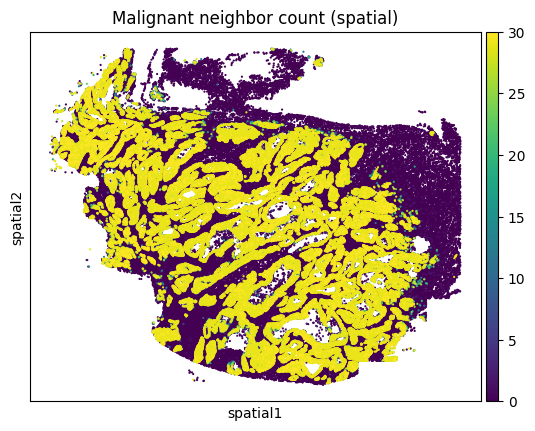

In [33]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color="mal_count",
    size=10,
    cmap="viridis",
    vmax=30,
    title="Malignant neighbor count (spatial)"
)


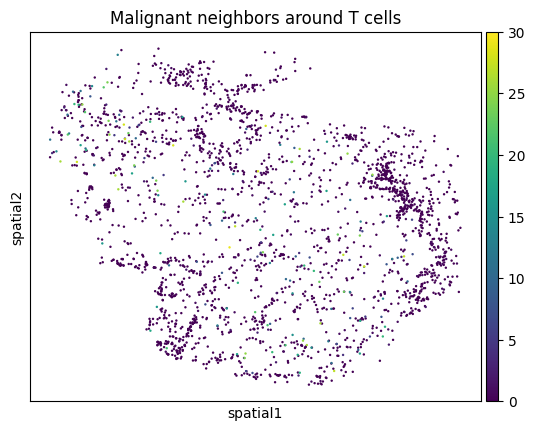

In [34]:
sc.pl.embedding(
    tcell,
    basis="spatial",
    color="mal_count",
    size=12,
    cmap="viridis",
    vmax=30,
    title="Malignant neighbors around T cells"
)


In [14]:
# -------------------------
# 3) Build state X = [genes(24), met_tasks(100), rxn(~90), Tumor-Infiltrating Lymphocytes-TIL(1)]
#    Use smoothed_X if exists; else use X
# -------------------------
if "smoothed_X" in tcell.layers:
    X_gene = to_dense(tcell.layers["smoothed_X"]).astype(np.float32)
else:
    X_gene = to_dense(tcell.X).astype(np.float32)

X_task = np.asarray(tcell.obsm["met_tasks"], dtype=np.float32)
X_rxn  = np.asarray(tcell.obsm["rxn"], dtype=np.float32)
X_til  = tcell.obs["TIL_score_z"].to_numpy().reshape(-1, 1).astype(np.float32)

X_mal_frac = (
    tcell.obs["mal_count"].to_numpy() / 30.0
).reshape(-1, 1).astype(np.float32)


# Concatenate all dimensions
X = np.concatenate(
    [X_gene, X_task, X_rxn, X_til, X_mal_frac],
    axis=1
).astype(np.float32)

X, X_mu, X_sd = zscore(X)
print("State X:", X.shape)


# For pseudotime + state-graph similarity, use metabolic only:
X_meta = np.concatenate([X_task, X_rxn], axis=1).astype(np.float32)
X_meta, meta_mu, meta_sd = zscore(X_meta)
print("Metabolic X_meta:", X_meta.shape)

State X: (2446, 206)
Metabolic X_meta: (2446, 180)


In [17]:
# -------------------------
# 4) Pseudotime (DPT) on metabolic features
# -------------------------
adata_pt = ad.AnnData(X_meta)

# neighbors in metabolic space
sc.pp.neighbors(adata_pt, n_neighbors=30, metric="cosine")
sc.tl.diffmap(adata_pt)

# Choose root cell:
# simplest: lowest total metabolic activation (sum of original tasks, not zscored)
root = int(np.argmin(X_task.sum(axis=1)))
adata_pt.uns["iroot"] = root

sc.tl.dpt(adata_pt)
pt = adata_pt.obs["dpt_pseudotime"].to_numpy()
pt = (pt - pt.min()) / (pt.max() - pt.min() + 1e-8)
print("pseudotime in [", pt.min(), ",", pt.max(), "]")

pseudotime in [ 0.0 , 1.0 ]


In [18]:
# -------------------------
# 5) Bin pseudotime into discrete steps for training
# -------------------------
n_bins = 20
pt_bin = np.floor(pt * n_bins).astype(int)
pt_bin[pt_bin == n_bins] = n_bins - 1
print("bins:", pt_bin.min(), "->", pt_bin.max())

bins: 0 -> 19


In [ ]:
# -------------------------
# 6) Build Spatial Graph for T cells
#    Extract a T-cell–only subgraph from the full spatial kNN graph
## This graph encodes spatial proximity between T cells
# and is used as the structural backbone for spatial GNN modeling.
# -------------------------

# G_full: full kNN spatial connectivity graph for all cells (N x N)
# idx_t: indices of T cells in the full AnnData object

# Subset the full graph to keep only T-cell ↔ T-cell connections
# Resulting matrix size: (n_Tcells x n_Tcells)
G_sp = G_full[idx_t[:, None], idx_t].tocoo()

# Extract source and destination node indices from sparse matrix
src_sp = G_sp.row
dst_sp = G_sp.col

# Remove self-loops (edges from a node to itself)
# These are not informative for spatial interaction modeling
m = (src_sp != dst_sp)
src_sp, dst_sp = src_sp[m], dst_sp[m]

# Build edge index in standard GNN format: shape (2, n_edges)
# Row 0: source nodes
# Row 1: destination nodes
edge_spatial = np.stack([src_sp, dst_sp], axis=0).astype(np.int64)

# Sanity check: number of spatial edges between T cells
print("Spatial edges:", edge_spatial.shape[1])


Spatial edges: 13176


In [20]:
# -------------------------
# 7) Build State Similarity Graph (kNN) in metabolic space
# -------------------------

# Number of nearest neighbors in feature (metabolic) space
# Kept small to avoid overly dense graphs
k_feat = 15

# Build kNN model using cosine similarity on metabolic features
# Each node = one T cell
nn_k = NearestNeighbors(
    n_neighbors=k_feat + 1,  # +1 because the first neighbor is the cell itself
    algorithm="auto",
    metric="cosine"
)

# Fit kNN model on metabolic state matrix
nn_k.fit(X_meta)

# Get indices of nearest neighbors for each T cell
idxs = nn_k.kneighbors(X_meta, return_distance=False)

# Build edge list:
# For each node i, connect it to its k nearest metabolic neighbors
src = np.repeat(np.arange(X_meta.shape[0]), k_feat)
dst = idxs[:, 1:].reshape(-1)  # skip self-neighbor at index 0

# Edge index in standard GNN format (2, n_edges)
edge_state = np.stack([src, dst], axis=0).astype(np.int64)

# Sanity check: number of state-based edges
print("State edges:", edge_state.shape[1])

State edges: 36690


In [21]:
# -------------------------
# 8) Build training target: state transition direction
#    dx_target[i] = mean_state(next_bin) - current_state[i]
#    Only cells whose pseudotime bin has a valid next bin are used for training
# -------------------------

# Dimensionality of the state vector
D = X.shape[1]

# Store mean state vector for each pseudotime bin
bin_means = np.zeros((n_bins, D), dtype=np.float32)

# Number of cells in each pseudotime bin
bin_counts = np.zeros(n_bins, dtype=np.int64)

# Compute mean state for each pseudotime bin
for b in range(n_bins):
    mask = (pt_bin == b)          # cells belonging to bin b
    bin_counts[b] = mask.sum()    # how many cells in this bin
    if bin_counts[b] > 0:
        bin_means[b] = X[mask].mean(axis=0)

# Determine which cells are valid for training
# A cell is valid if:
#   - it is in bin b
#   - bin b+1 exists and is non-empty
valid = np.zeros(X.shape[0], dtype=bool)
for b in range(n_bins - 1):
    if bin_counts[b] > 0 and bin_counts[b + 1] > 0:
        valid |= (pt_bin == b)

# Initialize target displacement vectors (same shape as X)
# For invalid cells, the target remains zero and will be ignored in loss
dx_target = np.zeros_like(X, dtype=np.float32)

# Compute target displacement for valid bins
# Each cell is trained to move toward the mean state of the next pseudotime bin
for b in range(n_bins - 1):
    if bin_counts[b] > 0 and bin_counts[b + 1] > 0:
        mask = (pt_bin == b)
        dx_target[mask] = bin_means[b + 1] - X[mask]

# Sanity check: number of cells used for training
print("Train nodes:", valid.sum(), "/", X.shape[0])


Train nodes: 2420 / 2446


In [22]:
# -------------------------
# 9) Dual-graph GNN for predicting state change (dx)
# -------------------------
# The model uses two graphs:
#   1) Spatial graph: physical proximity between T cells
#   2) State graph: similarity in metabolic state
# The outputs from both graphs are combined to predict dx

class TemporalGNN(nn.Module):
    def __init__(self, d_in, d_h=256):
        super().__init__()

        # Spatial graph branch (physical neighborhood)
        self.sp1 = SAGEConv(d_in, d_h)
        self.sp2 = SAGEConv(d_h, d_h)

        # State graph branch (metabolic similarity)
        self.st1 = SAGEConv(d_in, d_h)
        self.st2 = SAGEConv(d_h, d_h)

        # MLP to merge both embeddings and predict dx
        self.mlp = nn.Sequential(
            nn.Linear(2 * d_h, d_h),
            nn.ReLU(),
            nn.Linear(d_h, d_in)
        )

    def forward(self, x, edge_sp, edge_st):
        # ----- Spatial message passing -----
        # Aggregate information from spatial neighbors
        h_sp = F.relu(self.sp1(x, edge_sp))
        h_sp = F.relu(self.sp2(h_sp, edge_sp))

        # ----- State (metabolic) message passing -----
        # Aggregate information from metabolically similar cells
        h_st = F.relu(self.st1(x, edge_st))
        h_st = F.relu(self.st2(h_st, edge_st))

        # Concatenate spatial and state embeddings
        h = torch.cat([h_sp, h_st], dim=1)

        # Predict state change (dx)
        dx = self.mlp(h)
        return dx


In [ ]:
# -------------------------
# 10) Train (full-batch)
# -------------------------
x_t = torch.tensor(X, dtype=torch.float32, device=device)
dx_t = torch.tensor(dx_target, dtype=torch.float32, device=device)
mask_t = torch.tensor(valid, dtype=torch.bool, device=device)

edge_sp_t = torch.tensor(edge_spatial, dtype=torch.long, device=device)
edge_st_t = torch.tensor(edge_state, dtype=torch.long, device=device)

model = TemporalGNN(d_in=D, d_h=256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.train()
for epoch in range(1, 51):
    dx_pred = model(x_t, edge_sp_t, edge_st_t)
    loss = F.mse_loss(dx_pred[mask_t], dx_t[mask_t])

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:03d} | loss={loss.item():.6f}")

In [ ]:
# -------------------------
# 10) Train with cosine-similarity monitoring (directional learning)
# -------------------------

# Convert numpy arrays to torch tensors and move to device (CPU/GPU)
x_t = torch.tensor(X, dtype=torch.float32, device=device)          # node states
dx_t = torch.tensor(dx_target, dtype=torch.float32, device=device) # target state change
mask_t = torch.tensor(valid, dtype=torch.bool, device=device)      # valid training nodes

# Graph edges (PyTorch Geometric format)
edge_sp_t = torch.tensor(edge_spatial, dtype=torch.long, device=device)  # spatial graph
edge_st_t = torch.tensor(edge_state, dtype=torch.long, device=device)    # state graph

# Initialize model and optimizer
model = TemporalGNN(d_in=D, d_h=256).to(device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

# Training loop
model.train()

best_cos = -1.0          # best average cosine similarity seen so far
patience = 0
max_patience = 5         # early stopping patience
epochs = 50

for epoch in range(1, epochs):

    # Forward pass
    dx_pred = model(x_t, edge_sp_t, edge_st_t)

    # MSE loss (only on valid nodes)
    loss = F.mse_loss(dx_pred[mask_t], dx_t[mask_t])

    # Backprop
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    # ---- Directional evaluation (cosine similarity) ----
    with torch.no_grad():
        cos_sim = F.cosine_similarity(
            dx_pred[mask_t],
            dx_t[mask_t],
            dim=1
        ).mean().item()

    # Early stopping based on cosine similarity
    if cos_sim > best_cos + 1e-4:
        best_cos = cos_sim
        patience = 0
    else:
        patience += 1

    # Logging
    if epoch % 5 == 0 or epoch == 1:
        print(
            f"epoch {epoch:03d} | "
            f"loss={loss.item():.6f} | "
            f"cos(dx_pred, dx_target)={cos_sim:.4f}"
        )

    # Stop if direction no longer improves
    if patience >= max_patience:
        print(f"Early stopping at epoch {epoch} (cosine similarity plateau)")
        break


epoch 001 | loss=0.835674 | cos(dx_pred, dx_target)=-0.0040
epoch 005 | loss=0.706055 | cos(dx_pred, dx_target)=0.3832
epoch 010 | loss=0.480014 | cos(dx_pred, dx_target)=0.5789
epoch 015 | loss=0.356051 | cos(dx_pred, dx_target)=0.6847
epoch 020 | loss=0.280558 | cos(dx_pred, dx_target)=0.7445
epoch 025 | loss=0.226166 | cos(dx_pred, dx_target)=0.7922
epoch 030 | loss=0.187469 | cos(dx_pred, dx_target)=0.8244
epoch 035 | loss=0.170654 | cos(dx_pred, dx_target)=0.8391
epoch 040 | loss=0.144165 | cos(dx_pred, dx_target)=0.8593
epoch 045 | loss=0.127887 | cos(dx_pred, dx_target)=0.8714
epoch 050 | loss=0.116958 | cos(dx_pred, dx_target)=0.8805


In [35]:
# -------------------------
# 11) Inference / Generation
#     Roll the learned vector field forward in state space
#     x_{k+1} = x_k + alpha * dx_pred
# -------------------------

@torch.no_grad()  # Disable gradient computation (inference only)
def roll_forward(model, x0, edge_sp, edge_st, steps=10, alpha=1.0):
    """
    Roll the state forward in time using the learned dx field.

    Parameters
    ----------
    model : trained TemporalGNN
        Predicts dx given current state and graphs
    x0 : Tensor (N x D)
        Initial state (normalized feature space)
    edge_sp : Tensor
        Spatial graph edges
    edge_st : Tensor
        State (metabolic similarity) graph edges
    steps : int
        Number of rollout steps
    alpha : float
        Step size (integration scale)

    Returns
    -------
    x : Tensor (N x D)
        Generated future states after rollout
    """
    model.eval()        # Switch to evaluation mode
    x = x0.clone()      # Start from initial state

    for _ in range(steps):
        # Predict state change (dx) at current state
        dx = model(x, edge_sp, edge_st)

        # Update state using Euler integration
        x = x + alpha * dx

    return x


# Example: generate "future-like" states from current states
x_gen = roll_forward(
    model,
    x_t,
    edge_sp_t,
    edge_st_t,
    steps=20,
    alpha=0.3
)

# Convert back from z-scored space to original feature scale
X_gen = (x_gen.detach().cpu().numpy() * X_sd) + X_mu

print("Generated states:", X_gen.shape)

Generated states: (2446, 206)


## Visualization

In [36]:
task_start = X_gene.shape[1]
task_end   = task_start + X_task.shape[1]

k = 3  # index of metabolic task

feat_orig = X[:, task_start + k]
feat_gen  = X_gen[:, task_start + k]

In [37]:
adata.obs["task_orig"] = np.nan
adata.obs["task_gen"]  = np.nan

adata.obs.loc[tcell.obs_names, "task_orig"] = feat_orig
adata.obs.loc[tcell.obs_names, "task_gen"]  = feat_gen

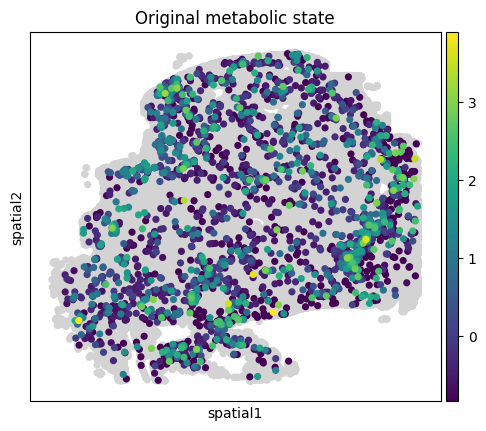

In [38]:
sc.pl.spatial(
    adata,
    color="task_orig",
    size=10,
    spot_size=100,
    cmap="viridis",
    title="Original metabolic state"
)


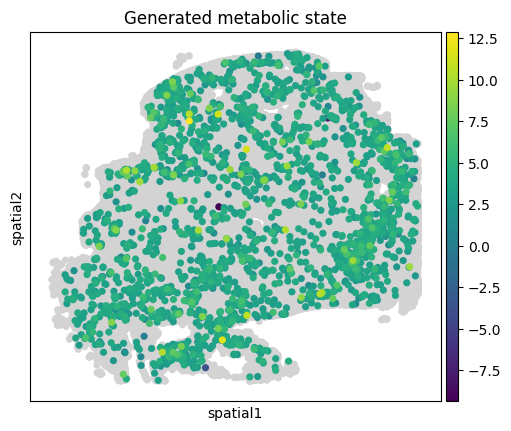

In [39]:
sc.pl.spatial(
    adata,
    color="task_gen",
    size=10,
    cmap="viridis",
    spot_size=100,
    title="Generated metabolic state"
)


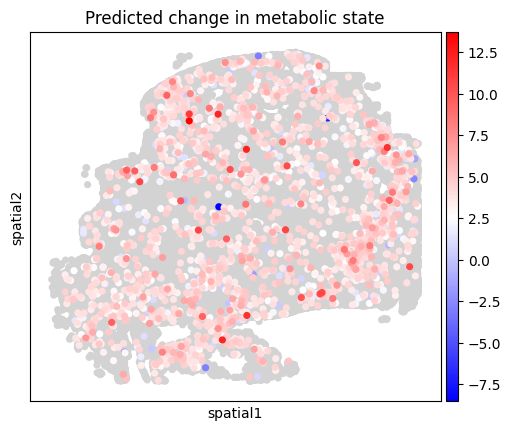

In [40]:
adata.obs["task_delta"] = adata.obs["task_gen"] - adata.obs["task_orig"]

sc.pl.spatial(
    adata,
    color="task_delta",
    size=10,
    spot_size=100,
    cmap="bwr",
    title="Predicted change in metabolic state"
)
